# ElasticNet Model Development

The purpose of this notebook is to:

1. Read in preprocessed data
2. Declare parameter grid
3. Perform cross validation pipeline
4. Train and export a final model and test scores

## Import necessary packages

In [101]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import ParameterGrid, GridSearchCV, KFold, train_test_split

from sklearn.metrics import mean_squared_error

## Read in the preprocessed (feature engineered) dataset

In [102]:
df = pd.read_csv("../data/preprocessed.csv")
df.columns, df.shape

(Index(['title', 'runtimeMinutes', 'averageRating', 'numVotes', 'director',
        'writer', 'productionBudget', 'domesticGross', 'worldwideGross',
        'releaseYear', 'releaseMonth', 'releaseDay', 'genre-1', 'genre-2',
        'genre-3', 'budgetYear', 'domesticGrossYear', 'worldwideGrossYear'],
       dtype='object'),
 (1307, 18))

In [103]:
target = "averageRating"
X = df.drop(columns=[target])
y = df[target]

In [104]:
drop_ftrs = ['title']
cat_ftrs = ['director', 'writer', 'genre-1', 'genre-2', 'genre-3']
ordinal_ftrs = ['releaseYear', 'releaseMonth', 'releaseDay']
ordinal_cats = [sorted(df["releaseYear"].unique()), [1,2,3,4,5,6,7,8,9,10,11,12], \
                [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]]
num_ftrs = ['runtimeMinutes', 'numVotes', 'productionBudget', 'domesticGross', 'worldwideGross', \
            'budgetYear', 'domesticGrossYear', 'worldwideGrossYear']

# one-hot encoder
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))])

# ordinal encoder
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
prep = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs),
        ('drop', 'drop', drop_ftrs)])

assert len(X.columns) == len(drop_ftrs) + len(cat_ftrs) + len(ordinal_ftrs) + len(num_ftrs)

## Declare a parameter grid

In [105]:
param_grid = {
    "model__alpha": np.logspace(-4,4,5),
    "model__l1_ratio": np.linspace(0,1,5),
    "model__tol": [0.5]
}

## Perform the machine learning cross validation pipeline

The pipeline is as follows:

1. Define K-Fold and pipeline (preprocessor + model regressor)
2. Perform GridSearch cross validation using defined 5 split K-Fold and pipeline defined
3. Score based on negative MSE, since GridSearchCV maximizes scores
4. Fit GridSearch

In [107]:
nrand = 5

r_test_mse = []
r_best_params = []
r_pipe = []

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

for i in range(nrand):
    print(f"random state #{i}")
    kf = KFold(n_splits=5, shuffle=True, random_state=i)
    
    pipe = Pipeline(steps=[('prep', prep),
                           ('model', ElasticNet())])
    
    # CV
    grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', verbose=1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    print(f"best params from CV: {best_params}")
    
    # Final Model
    final_pipe = Pipeline(steps=[('prep', prep), 
                                 ('model', ElasticNet())])
    final_pipe.set_params(**best_params)
    final_pipe.fit(X_train, y_train)
    
    test_mse = mean_squared_error(final_pipe.predict(X_test), y_test)
    print(f"test mse: {test_mse}")

    # save random state values
    r_test_mse.append(test_mse)
    r_best_params.append(best_params)
    r_pipe.append(final_pipe)

best_mse_i = np.argmin(r_test_mse)
best_params = r_best_params[best_mse_i]
final_pipe = r_pipe[best_mse_i]
print(f"mse: {np.mean(r_test_mse)} +- {np.std(r_test_mse)}")

random state #0
Fitting 5 folds for each of 25 candidates, totalling 125 fits
best params from CV: {'model__alpha': 0.01, 'model__l1_ratio': 0.25, 'model__tol': 0.5}
test mse: 0.7557470269125138
random state #1
Fitting 5 folds for each of 25 candidates, totalling 125 fits
best params from CV: {'model__alpha': 0.01, 'model__l1_ratio': 0.25, 'model__tol': 0.5}
test mse: 0.7557470269125138
random state #2
Fitting 5 folds for each of 25 candidates, totalling 125 fits
best params from CV: {'model__alpha': 0.01, 'model__l1_ratio': 0.25, 'model__tol': 0.5}
test mse: 0.7557470269125138
random state #3
Fitting 5 folds for each of 25 candidates, totalling 125 fits
best params from CV: {'model__alpha': 0.01, 'model__l1_ratio': 0.0, 'model__tol': 0.5}
test mse: 0.7424287510784384
random state #4
Fitting 5 folds for each of 25 candidates, totalling 125 fits
best params from CV: {'model__alpha': 0.01, 'model__l1_ratio': 0.0, 'model__tol': 0.5}
test mse: 0.7424287510784384
mse: 0.7504197165788836 +- 

## Train and export a final model and test scores

In [108]:
from joblib import dump

dump({'model': final_pipe.named_steps['model'], 'pipe': final_pipe, 'params': best_params, 'test_mses': r_test_mse}, \
     '../results/elasticnet_results.joblib')

['../results/elasticnet_results.joblib']

## Training set size

In [109]:
nrand = 5

r_test_mse = []
r_best_params = []
r_pipe = []
train_size = []
cv_mse = []

for i in [1,2,4,6,8]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=i/10, random_state=42)
    train_size.append(X_train.shape[0])
    print(f"random state #{i}")
    kf = KFold(n_splits=5, shuffle=True, random_state=i)
    
    pipe = Pipeline(steps=[('prep', prep),
                           ('model', ElasticNet())])
    
    # CV
    grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', verbose=1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    print(f"best params from CV: {best_params}")
    cv_mse.append(-grid_search.best_score_)
    
    # Final Model
    final_pipe = Pipeline(steps=[('prep', prep), 
                                 ('model', ElasticNet())])
    final_pipe.set_params(**best_params)
    final_pipe.fit(X_train, y_train)
    
    test_mse = mean_squared_error(final_pipe.predict(X_test), y_test)
    print(f"test mse: {test_mse}")

    # save random state values
    r_test_mse.append(test_mse)
    r_best_params.append(best_params)
    r_pipe.append(final_pipe)

best_mse_i = np.argmin(r_test_mse)
best_params = r_best_params[best_mse_i]
final_pipe = r_pipe[best_mse_i]
print(f"mse: {np.mean(r_test_mse)} +- {np.std(r_test_mse)}")

random state #1
Fitting 5 folds for each of 25 candidates, totalling 125 fits
best params from CV: {'model__alpha': 0.01, 'model__l1_ratio': 0.25, 'model__tol': 0.5}
test mse: 0.79796981359204
random state #2
Fitting 5 folds for each of 25 candidates, totalling 125 fits
best params from CV: {'model__alpha': 1.0, 'model__l1_ratio': 0.0, 'model__tol': 0.5}
test mse: 0.8477520963887144
random state #4
Fitting 5 folds for each of 25 candidates, totalling 125 fits
best params from CV: {'model__alpha': 0.01, 'model__l1_ratio': 0.25, 'model__tol': 0.5}
test mse: 0.6802529232642928
random state #6
Fitting 5 folds for each of 25 candidates, totalling 125 fits
best params from CV: {'model__alpha': 0.01, 'model__l1_ratio': 0.5, 'model__tol': 0.5}
test mse: 0.7084286009323254
random state #8
Fitting 5 folds for each of 25 candidates, totalling 125 fits
best params from CV: {'model__alpha': 0.01, 'model__l1_ratio': 0.25, 'model__tol': 0.5}
test mse: 0.7557470269125138
mse: 0.7580300922179772 +- 0.0

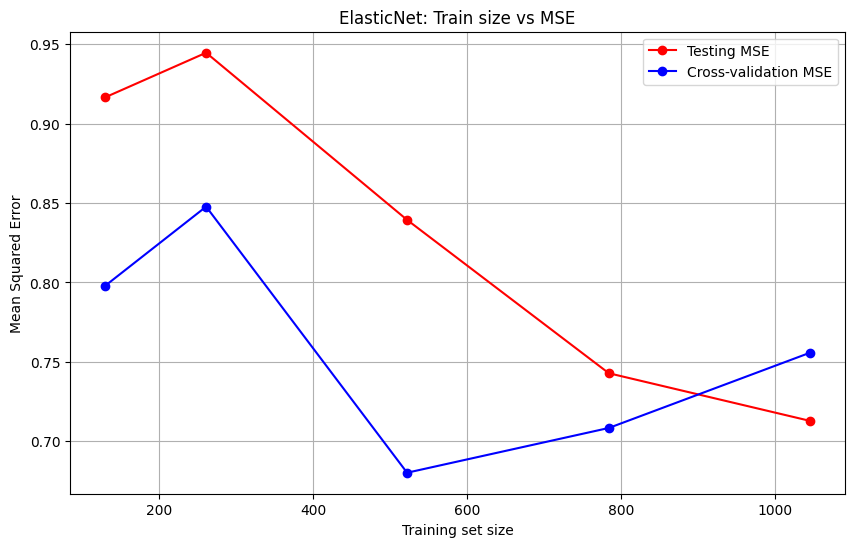

In [111]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(train_size, cv_mse, 'o-', color="r", label="Testing MSE")
plt.plot(train_size, r_test_mse, 'o-', color="b", label="Cross-validation MSE")
plt.xlabel("Training set size")
plt.ylabel("Mean Squared Error")
plt.title("ElasticNet: Train size vs MSE")
plt.legend(loc="best")
plt.grid()
plt.savefig('../figures/elasticnet_train_vs_mse.png', dpi=1000)
plt.show()